<a href="https://colab.research.google.com/github/musajalili/TCN4CropTypeMapping/blob/main/DaSET2025_TCN_KPK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Temporal Convolutional Networks for Multi-Temporal Crop Classification in Khyber Pakhtunkhwa Using Sentinel‑2 and ADB Ground‑Truth Surveys

**Colab Notebook — Implementation Pack (DaSET 2025)**

This notebook provides an end‑to‑end pipeline:
1) Data acquisition & preprocessing with Google Earth Engine (GEE) for Sentinel‑2 (Level‑2A SR)  
2) Ground‑truth integration using ADB Rabi 2022–Kharif 2023 survey points  
3) Temporal feature extraction (NDVI, NDWI, and NBR) and dataset creation  
4) TCN/TempCNN training (PyTorch), evaluation, and export of results

> Before running: open with **Google Colab** and execute cells in order.  
> Replace placeholders (PROJECT_ID, date ranges, file paths) as needed.



**Key References**
- Sentinel‑2 L2A product description (Copernicus): see product characteristics and bands.  
- Earth Engine s2cloudless cloud‑masking tutorial (GEE Developers).  
- Temporal Conv Nets for sequence modeling (Bai, Kolter, Koltun, 2018).  
- TempCNN for Satellite Image Time Series classification (Pelletier et al., 2019).

(Full citations are in the paper; this notebook is for implementation.)


In [1]:

# === Environment setup (Colab) ===
!pip -q install earthengine-api geemap pandas geopandas shapely pyproj rasterio fiona rtree pyarrow torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.2 MB/s eta 0:00:00


In [2]:

# === Authenticate & Initialize Earth Engine ===
import ee, os, json, pandas as pd, numpy as np
try:
    import geemap
except Exception as e:
    print("geemap not available yet; restart the runtime if needed.", e)

# If running in Colab:
# from google.colab import auth
# auth.authenticate_user()

# Provide your GEE project ID (for large exports)
PROJECT_ID = "vast-alcove-262310"  # <-- TODO: set
try:
    ee.Initialize(project=PROJECT_ID)
except Exception:
    ee.Authenticate()
    ee.Initialize(project=PROJECT_ID)

print("EE initialized.")


EE initialized.


In [3]:
fc = ee.FeatureCollection("projects/vast-alcove-262310/assets/fiveKPKcrops")

print("FeatureCollection created with", fc.size().getInfo(), "features")

FeatureCollection created with 7098 features


In [4]:

# === Study Area (Khyber Pakhtunkhwa) from GAUL level1 ===
# You can replace this with your custom AOI (e.g., uploaded GeoJSON) if desired.
# Load GAUL dataset (adjust depending on which GAUL collection you're using)
gaul = ee.FeatureCollection("FAO/GAUL/2015/level2")



# Filter for KPK
kp = gaul.filter(
    ee.Filter.And(
        ee.Filter.eq('ADM1_CODE', 2275)
    )
).geometry()

# (Optional) Buffer/clip to avoid edge artifacts
aoi = kp
Map = geemap.Map()
Map.centerObject(aoi, 7)
Map.addLayer(aoi, {}, "AOI (Khyber Pakhtunkhwa)")

# Add the FeatureCollection to the map
Map.addLayer(fc, {}, "My FeatureCollection")

# Center map on the FeatureCollection
Map.centerObject(fc, 9)

# Display map
# Map


In [ ]:
aoi = Map.draw_last_feature.geometry()

In [ ]:
def mask_s2_sr_cldprob(img):
    # Get cloud probability image
    cld_prb = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY') \
        .filterBounds(aoi) \
        .filterDate(img.date(), img.date().advance(1, 'day')) \
        .first()

    # If no cloud probability image, return the original img with valid bands
    cld_prb = ee.Algorithms.If(
        cld_prb,
        cld_prb.rename('cloud_prob'),
        ee.Image.constant(0).rename('cloud_prob').clip(aoi)
    )

    img = img.addBands(ee.Image(cld_prb))

    # Cloud mask
    is_cloud = img.select('cloud_prob').gt(60)
    nir = img.select('B8')
    dark_pixels = nir.lt(0.15)
    shadow = dark_pixels.And(is_cloud.focal_min(3))
    mask = is_cloud.Or(shadow).Not()

    return img.updateMask(mask).select(['B2','B3','B4','B8','B11','B12','QA60'])


In [ ]:
def add_indices(img):
    # Scale reflectance if needed (S2 SR is in reflectance [0..1] in GEE)
    ndvi = img.normalizedDifference(['B8','B4']).rename('NDVI')
    ndwi = img.normalizedDifference(['B3','B8']).rename('NDWI')
    nbr  = img.normalizedDifference(['B8','B12']).rename('NBR')
    return img.addBands([ndvi, ndwi, nbr])

In [ ]:

# === Build Sentinel-2 time series ===
start_date = '2022-10-01'  # Rabi window start
end_date   = '2023-10-30'  # through Kharif
s2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60))
        .map(mask_s2_sr_cldprob)
        .map(add_indices))

# Temporal aggregation: monthly median composites (adjust period if needed)
def month_key(img):
    d = ee.Date(img.get('system:time_start'))
    return d.format('YYYY-MM')

months = ee.List.sequence(
    0,
    ee.Date(end_date).difference(ee.Date(start_date), 'month')
).map(lambda n: ee.Date(start_date).advance(n, 'month').format('YYYY-MM'))


def monthly_median(ym):
    ym = ee.String(ym)
    y = ee.Number.parse(ym.slice(0,4))
    m = ee.Number.parse(ym.slice(5,7))
    start = ee.Date.fromYMD(y, m, 1)
    stop  = start.advance(1, 'month')
    comp = s2.filterDate(start, stop).median().set('month', ym).set('system:time_start', start.millis())
    return comp

monthly = ee.ImageCollection(ee.List(months.map(monthly_median)))
print('Monthly composites:', monthly.size().getInfo())


Monthly composites: 13


In [ ]:

# === Sample time series at GT points ===
# Stack monthly composites into a single multiband image (bands include original + indices for each month)
band_names = ['B2','B3','B4','B8','B11','B12','NDVI','NDWI','NBR']
def rename_with_month(img):
    m = ee.String(img.get('month'))
    old = img.bandNames()
    new = old.map(lambda b: ee.String(b).cat('_').cat(m))
    return img.select(old, new)

stacked = monthly.map(rename_with_month).toBands()
stacked = stacked.clip(aoi)

# Sample all points
if fc.size().getInfo() > 0:
    samples = stacked.sampleRegions(
        collection=fc,
        properties=['Description'],
        scale=10,
        geometries=False
    )

In [ ]:
task = ee.batch.Export.table.toDrive(
    collection=samples,
    description='KPK_MainCrops_ts',
    fileFormat='CSV'
)
task.start()


#CSV to PARQUET

In [ ]:
import pandas as pd

csv_path = "/content/KK_MainCrops_ts.csv"
parquet_path = "/content/kp_main_timeseries.parquet"

df = pd.read_csv(csv_path)
df.to_parquet(parquet_path, index=False)

print("Saved Parquet:", parquet_path)


Saved Parquet: /content/kp_main_timeseries.parquet


In [ ]:
df.columns

Index(['system:index', '0_B11_2022-10', '0_B12_2022-10', '0_B2_2022-10',
       '0_B3_2022-10', '0_B4_2022-10', '0_B8_2022-10', '0_NBR_2022-10',
       '0_NDVI_2022-10', '0_NDWI_2022-10',
       ...
       '9_B2_2023-07', '9_B3_2023-07', '9_B4_2023-07', '9_B8_2023-07',
       '9_NBR_2023-07', '9_NDVI_2023-07', '9_NDWI_2023-07', '9_QA60_2023-07',
       'Description', '.geo'],
      dtype='object', length=133)

# ML

In [ ]:
!pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

#remove numeric prefixes like "0_"

In [ ]:
import pandas as pd, numpy as np, os, json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

PARQUET = '/content/kp_main_timeseries.parquet'
if os.path.exists(PARQUET):
    data = pd.read_parquet(PARQUET)

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(data['Description'].astype(str))
    X = data.drop(columns=['Description'])

    # Inspect columns
    print("Sample columns:", X.columns[:15].tolist())

    # === Parse band and month from column names ===
    def parse_band(col):
        parts = col.split('_')
        if len(parts) >= 2:
            # Case: "0_B11_2022-10" -> "B11"
            if parts[0].isdigit():
                return parts[1]
            else:
                return parts[0]
        return None

    def parse_month(col):
        parts = col.split('_')
        return parts[-1] if len(parts) >= 2 else None

    cols = list(X.columns)
    month_tags = sorted({parse_month(c) for c in cols if parse_month(c)})
    bands = sorted({parse_band(c) for c in cols if parse_band(c)})
    bands = [b for b in bands if b in ['B2','B3','B4','B8','B11','B12','NDVI','NDWI','NBR']]

    C = len(bands)
    T = len(month_tags)
    print("Month tags:", month_tags)
    print("Bands:", bands, "| Channels:", C, "| Timesteps:", T)

    if C == 0:
        raise ValueError("No valid bands found in parquet file!")

    # === Build tensor ===
    X_tsr = np.zeros((len(X), C, T), dtype=np.float32)
    for bi, b in enumerate(bands):
        for ti, m in enumerate(month_tags):
            # match regardless of numeric prefix
            matches = [c for c in cols if f"_{b}_{m}" in c]
            if matches:
                X_tsr[:, bi, ti] = X[matches[0]].astype(np.float32).fillna(0).values

    # Oversample classes
    nsamples = X_tsr.shape[0]
    X_flat = X_tsr.reshape(nsamples, -1)
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(X_flat, y)
    X_tsr = X_resampled.reshape(-1, C, T)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_tsr, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
    )

    # Save
    np.save('/content/X_train.npy', X_train)
    np.save('/content/X_test.npy', X_test)
    np.save('/content/y_train.npy', y_train)
    np.save('/content/y_test.npy', y_test)
    with open('/content/label_mapping.json','w') as f:
        json.dump({int(i): cls for i, cls in enumerate(le.classes_)}, f)

    print("✅ Prepared dataset:", X_train.shape, X_test.shape,
          C, "channels,", T, "timesteps")
else:
    print("Missing /content/kp_timeseries.parquet. Run previous steps.")



Sample columns: ['system:index', '0_B11_2022-10', '0_B12_2022-10', '0_B2_2022-10', '0_B3_2022-10', '0_B4_2022-10', '0_B8_2022-10', '0_NBR_2022-10', '0_NDVI_2022-10', '0_NDWI_2022-10', '0_QA60_2022-10', '10_B11_2023-08', '10_B12_2023-08', '10_B2_2023-08', '10_B3_2023-08']
Month tags: ['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10']
Bands: ['B11', 'B12', 'B2', 'B3', 'B4', 'B8', 'NBR', 'NDVI', 'NDWI'] | Channels: 9 | Timesteps: 13
✅ Prepared dataset: (14520, 9, 13) (3630, 9, 13) 9 channels, 13 timesteps


In [ ]:
data.columns

Index(['system:index', '0_B11_2022-10', '0_B12_2022-10', '0_B2_2022-10',
       '0_B3_2022-10', '0_B4_2022-10', '0_B8_2022-10', '0_NBR_2022-10',
       '0_NDVI_2022-10', '0_NDWI_2022-10',
       ...
       '9_B2_2023-07', '9_B3_2023-07', '9_B4_2023-07', '9_B8_2023-07',
       '9_NBR_2023-07', '9_NDVI_2023-07', '9_NDWI_2023-07', '9_QA60_2023-07',
       'Description', '.geo'],
      dtype='object', length=133)

In [ ]:
# === TCN / TempCNN model (PyTorch) ===
import torch, torch.nn as nn, torch.nn.functional as F

class TemporalBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, d=1, dropout=0.1):
        super().__init__()
        pad = (k-1)*d // 2
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size=3, padding=pad, dilation=d)
        self.bn1 = nn.BatchNorm1d(out_ch)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size=3, padding=pad, dilation=d)
        self.bn2 = nn.BatchNorm1d(out_ch)
        self.dropout = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else None

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.dropout(out)
        out = self.conv2(out)
        out = F.relu(self.bn2(out))
        out = self.dropout(out)
        res = x if self.downsample is None else self.downsample(x)
        return F.relu(out + res)

class TCNClassifier(nn.Module):
    def __init__(self, in_ch, n_classes, n_blocks=4, base_ch=64, dropout=0.1):
        super().__init__()
        layers = []
        ch = in_ch
        for b in range(n_blocks):
            layers.append(TemporalBlock(ch, base_ch*(2**b), d=2**b, dropout=dropout))
            ch = base_ch*(2**b)
        self.tcn = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(ch, ch//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ch//2, n_classes)
        )
    def forward(self, x):
        # x: [B, C, T]
        z = self.tcn(x)
        z = self.pool(z)
        return self.head(z)

print("Model classes defined.")


Model classes defined.


In [ ]:

# === Train the model ===
import torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = np.load('/content/X_train.npy'); y_train = np.load('/content/y_train.npy')
X_test  = np.load('/content/X_test.npy');  y_test  = np.load('/content/y_test.npy')

n_classes = int(y_train.max()) + 1
in_ch, T = X_train.shape[1], X_train.shape[2]

train_ds = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_ds  = torch.utils.data.TensorDataset(torch.tensor(X_test),  torch.tensor(y_test))
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=128, shuffle=False)

model = TCNClassifier(in_ch=in_ch, n_classes=n_classes, n_blocks=4, base_ch=32, dropout=0.2).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
crit = torch.nn.CrossEntropyLoss()

best_acc = 0.0
patience, patience_cnt = 10, 0

for epoch in range(50):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device, dtype=torch.float32), yb.to(device, dtype=torch.long)
        opt.zero_grad()
        logits = model(xb)
        loss = crit(logits, yb)
        loss.backward()
        opt.step()
        loss_sum += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total += xb.size(0)
    train_acc = correct/total
    train_loss = loss_sum/total

    # eval
    model.eval()
    with torch.no_grad():
        total, correct = 0, 0
        all_pred, all_true = [], []
        for xb, yb in test_loader:
            xb, yb = xb.to(device, dtype=torch.float32), yb.to(device, dtype=torch.long)
            logits = model(xb)
            pred = logits.argmax(1)
            correct += (pred == yb).sum().item()
            total += xb.size(0)
            all_pred.append(pred.cpu().numpy()); all_true.append(yb.cpu().numpy())
        val_acc = correct/total
    print(f"Epoch {epoch+1:02d} | Train loss {train_loss:.4f} acc {train_acc:.3f} | Val acc {val_acc:.3f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), '/content/tcn_kp_best.pt')
        patience_cnt = 0
    else:
        patience_cnt += 1
        if patience_cnt >= patience:
            print("Early stopping.")
            break

print("Best val acc:", best_acc)


Epoch 01 | Train loss 1.4459 acc 0.552 | Val acc 0.722
Epoch 02 | Train loss 0.5941 acc 0.764 | Val acc 0.780
Epoch 03 | Train loss 0.5008 acc 0.792 | Val acc 0.817
Epoch 04 | Train loss 0.4490 acc 0.818 | Val acc 0.824
Epoch 05 | Train loss 0.4170 acc 0.831 | Val acc 0.839
Epoch 06 | Train loss 0.3901 acc 0.840 | Val acc 0.737
Epoch 07 | Train loss 0.3769 acc 0.844 | Val acc 0.849
Epoch 08 | Train loss 0.3563 acc 0.851 | Val acc 0.839
Epoch 09 | Train loss 0.3548 acc 0.853 | Val acc 0.842
Epoch 10 | Train loss 0.3509 acc 0.856 | Val acc 0.811
Epoch 11 | Train loss 0.3281 acc 0.863 | Val acc 0.818
Epoch 12 | Train loss 0.3195 acc 0.867 | Val acc 0.824
Epoch 13 | Train loss 0.3181 acc 0.869 | Val acc 0.834
Epoch 14 | Train loss 0.3162 acc 0.869 | Val acc 0.880
Epoch 15 | Train loss 0.2938 acc 0.875 | Val acc 0.845
Epoch 16 | Train loss 0.2912 acc 0.876 | Val acc 0.855
Epoch 17 | Train loss 0.2984 acc 0.872 | Val acc 0.877
Epoch 18 | Train loss 0.2799 acc 0.882 | Val acc 0.856
Epoch 19 |

In [ ]:

# === Detailed evaluation ===
import json, numpy as np, torch
from sklearn.metrics import classification_report, confusion_matrix
with open('/content/label_mapping.json') as f:
    id2label = {int(k):v for k,v in json.load(f).items()}

X_test  = np.load('/content/X_test.npy');  y_test  = np.load('/content/y_test.npy')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TCNClassifier(
    in_ch=X_test.shape[1],
    n_classes=len(id2label),
    n_blocks=4,
    base_ch=32,     # must match training
    dropout=0.2     # must match training
).to(device)

model.load_state_dict(torch.load('/content/tcn_kp_best.pt', map_location=device))
model.eval()


y_pred = []
with torch.no_grad():
    for i in range(0, len(X_test), 256):
        xb = torch.tensor(X_test[i:i+256]).to(device, dtype=torch.float32)
        logits = model(xb)
        y_pred.append(logits.argmax(1).cpu().numpy())
y_pred = np.concatenate(y_pred)

labels = [id2label[i] for i in sorted(id2label.keys())]
print(classification_report(y_test, y_pred, target_names=labels, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

       Maize      0.718     0.848     0.778       726
        Rice      0.958     0.997     0.977       726
   Sugarcane      0.911     0.964     0.937       726
     Tobacco      0.999     1.000     0.999       726
       Wheat      0.825     0.592     0.690       726

    accuracy                          0.880      3630
   macro avg      0.882     0.880     0.876      3630
weighted avg      0.882     0.880     0.876      3630

Confusion matrix:
 [[616   7  22   0  81]
 [  0 724   0   0   2]
 [ 16   2 700   0   8]
 [  0   0   0 726   0]
 [226  23  46   1 430]]


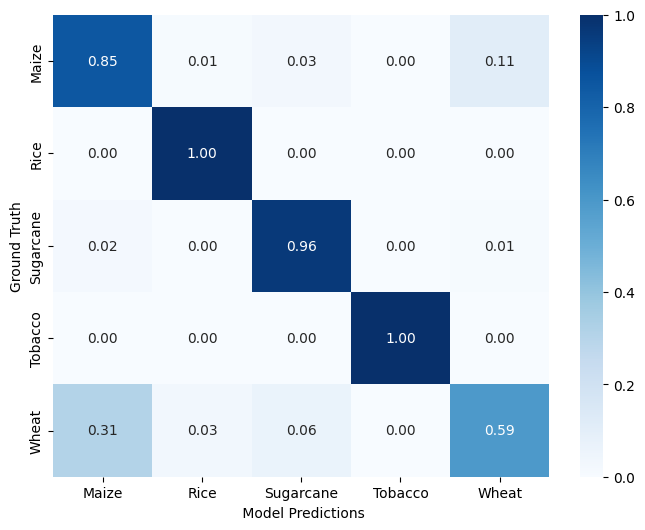

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel(" Model Predictions")
plt.ylabel("Ground Truth")
plt.title("")
plt.show()


In [ ]:
model = TCNClassifier(
    in_ch=X_test.shape[1],
    n_classes=len(id2label),
    n_blocks=4,
    base_ch=32,     # must match training
    dropout=0.2     # must match training
).to(device)

model.load_state_dict(torch.load('/content/tcn_kp_best.pt', map_location=device))
model.eval()


TCNClassifier(
  (tcn): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(9, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (downsample): Conv1d(9, 32, kernel_size=(1,), stride=(1,))
    )
    (1): TemporalBlock(
      (conv1): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (downsample): Conv1d(32, 64, kernel_size=(1,

In [ ]:

# === Save artifacts for the paper ===
import json, numpy as np
np.save('/content/y_pred.npy', y_pred)
with open('/content/labels.txt','w') as f:
    f.write("\n".join(labels))
print("Saved: /content/tcn_kp_best.pt, /content/y_pred.npy, /content/labels.txt")


Saved: /content/tcn_kp_best.pt, /content/y_pred.npy, /content/labels.txt


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 89.7 MB/s eta 0:00:00


In [ ]:
# === Export artifacts for figures (GeoTIFFs & CSVs) ===
# This cell attempts to export the required artifacts for figures:
#  - crop_map_TCN.tif (if a raster prediction or reference raster is available)
#  - sentinel_rgb_432.tif (if RGB bands are available in a reference raster)
#  - validation_points.csv (lat, lon, true_class, pred_class)
#  - ndvi_profiles.csv (date, class_name, mean_ndvi)
#  - confusion_matrix.csv
#
# IMPORTANT: This cell is written to be robust but depends on files/variables
# already present in the Colab runtime: '/content/y_pred.npy', '/content/label_mapping.json',
# '/content/kp_main_timeseries.parquet', '/content/X_test.npy', '/content/y_test.npy',
# and optionally a reference raster '/content/sentinel_reference.tif' that provides CRS/transform.
# If any of those files are missing, the cell will try fallbacks and print instructions.

import os, json, warnings
import numpy as np, pandas as pd

# Helper to save CSV
def save_csv(df, path):
    df.to_csv(path, index=False)
    print("Saved:", path)

# 1) Load labels and predictions
labels = None
if os.path.exists('/content/label_mapping.json'):
    with open('/content/label_mapping.json') as f:
        id2label = {int(k):v for k,v in json.load(f).items()}
    labels = [id2label[i] for i in sorted(id2label.keys())]
elif os.path.exists('/content/labels.txt'):
    with open('/content/labels.txt') as f:
        labels = [l.strip() for l in f if l.strip()]
else:
    print("Warning: label mapping not found at '/content/label_mapping.json' or '/content/labels.txt'.")

# y_pred
y_pred = None
if 'y_pred' in globals():
    y_pred = globals()['y_pred']
elif os.path.exists('/content/y_pred.npy'):
    y_pred = np.load('/content/y_pred.npy', allow_pickle=True)
    print("Loaded /content/y_pred.npy")
else:
    print("Warning: Predictions (y_pred) not found in variable or '/content/y_pred.npy'.")

# 2) Export confusion matrix CSV if y_test and y_pred exist
if os.path.exists('/content/y_test.npy') and y_pred is not None:
    from sklearn.metrics import confusion_matrix
    y_test = np.load('/content/y_test.npy', allow_pickle=True)
    cm = confusion_matrix(y_test, y_pred)
    # Save as DataFrame with label names if available
    if labels is not None and len(labels) == cm.shape[0]:
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    else:
        cm_df = pd.DataFrame(cm)
    save_csv(cm_df, '/content/confusion_matrix.csv')
else:
    print("Skipping confusion matrix export (missing y_test or y_pred).")

# 3) Export validation points CSV (with coordinates)
# Try to reconstruct mapping between samples and predictions:
val_out = '/content/validation_points.csv'
if os.path.exists('/content/kp_main_timeseries.parquet') and y_pred is not None:
    df_all = pd.read_parquet('/content/kp_main_timeseries.parquet')
    # Common coordinate column names
    lat_cols = [c for c in df_all.columns if c.lower() in ('lat','latitude','y','ycoord')]
    lon_cols = [c for c in df_all.columns if c.lower() in ('lon','longitude','x','xcoord')]
    if len(lat_cols)==0 or len(lon_cols)==0:
        print("No obvious lat/lon columns found in parquet. Columns:", df_all.columns.tolist()[:20])
    else:
        lat_col = lat_cols[0]
        lon_col = lon_cols[0]
        # Recreate the same train-test split used earlier if possible.
        # If X_test.npy and y_test.npy exist, we try to identify the test records by matching features.
        success = False
        if os.path.exists('/content/X_test.npy') and os.path.exists('/content/y_test.npy'):
            X_test = np.load('/content/X_test.npy', allow_pickle=True)
            y_test = np.load('/content/y_test.npy', allow_pickle=True)
            # Attempt to find matching rows in the parquet by comparing feature columns.
            # This is heuristic and may be slow for large tables.
            try:
                feat_cols = [c for c in df_all.columns if c not in ('Description', lat_col, lon_col, 'geometry')]
                df_feats = df_all[feat_cols].values
                # Build mapping by matching rows exactly (works if no floating rounding)
                # For safety, convert to strings and match
                df_keys = df_feats.astype(str).tolist()
                test_keys = X_test.astype(str).tolist()
                # Create dict of row indices keyed by string representation
                key_to_idx = {}
                for i,k in enumerate(df_keys):
                    key_to_idx.setdefault(tuple(k), []).append(i)
                matched_idx = []
                for k in test_keys:
                    tup = tuple(k)
                    if tup in key_to_idx and key_to_idx[tup]:
                        matched_idx.append(key_to_idx[tup].pop(0))
                if len(matched_idx) == len(X_test):
                    # Build validation DataFrame
                    val_df = pd.DataFrame({
                        'lat': df_all.loc[matched_idx, lat_col].values,
                        'lon': df_all.loc[matched_idx, lon_col].values,
                        'true_class': [str(x) for x in y_test],
                        'pred_class': [str(x) for x in y_pred[:len(matched_idx)]]
                    })
                    save_csv(val_df, val_out)
                    success = True
                else:
                    print(f"Matched {len(matched_idx)} / {len(X_test)} test rows by exact feature matching - skipping rasterization fallback.")
            except Exception as e:
                print("Heuristic matching failed:", e)
        if not success:
            # Fallback: if y_pred length matches df_all length, assume predictions align row-wise
            if len(y_pred) == len(df_all):
                val_df = pd.DataFrame({
                    'lat': df_all[lat_col].values,
                    'lon': df_all[lon_col].values,
                    'true_class': df_all.get('Description', pd.Series(['']*len(df_all))).astype(str).values,
                    'pred_class': [str(int(x)) for x in y_pred]
                })
                save_csv(val_df, val_out)
            else:
                print("Cannot create validation_points.csv automatically (y_pred length != number of records and test matching failed).")
else:
    print("Skipping validation CSV export (missing parquet or predictions).")

# 4) Export NDVI phenology CSV if NDVI columns exist in parquet
ndvi_out = '/content/ndvi_profiles.csv'
if os.path.exists('/content/kp_main_timeseries.parquet'):
    df_all = pd.read_parquet('/content/kp_main_timeseries.parquet')
    # find NDVI-like columns (by name containing 'NDVI' or 'ndvi')
    ndvi_cols = [c for c in df_all.columns if 'ndvi' in c.lower()]
    if ndvi_cols:
        # Melt into long format using 'Description' as class label if present
        melt = df_all[['Description'] + ndvi_cols].melt(id_vars=['Description'], value_vars=ndvi_cols,
                                                       var_name='date', value_name='ndvi')
        # Attempt to parse dates from column names if possible
        # Example ndvi_2021_04_15 -> try to extract '2021-04-15'
        melt['date'] = melt['date'].astype(str)
        # Compute mean per class per date
        prof = melt.groupby(['date', 'Description'])['ndvi'].mean().reset_index().rename(columns={'Description':'class_name','ndvi':'mean_ndvi'})
        save_csv(prof, ndvi_out)
    else:
        print("No NDVI columns found in parquet to build ndvi_profiles.csv. Columns:", df_all.columns.tolist()[:30])
else:
    print("Skipping NDVI profiles export (missing parquet).")

# 5) Export a GeoTIFF map if a raster prediction or reference raster exists
# Strategy A: If an array named 'prediction_array' or file '/content/prediction_raster.npy' exists -> write using ref raster metadata
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS
from rasterio.features import rasterize
from shapely.geometry import Point, mapping

written_any = False
# Attempt to write if prediction raster array exists
pred_raster_path = '/content/prediction_raster.npy'
if 'prediction_array' in globals():
    arr = globals()['prediction_array']
    # Try to use a reference raster to get metadata
    ref_path = '/content/sentinel_reference.tif'
    if os.path.exists(ref_path):
        with rasterio.open(ref_path) as ref:
            meta = ref.meta.copy()
        meta.update({'count':1, 'dtype': 'int16', 'compress':'lzw'})
        outname = '/content/crop_map_TCN.tif'
        with rasterio.open(outname, 'w', **meta) as dst:
            dst.write(arr.astype('int16'),1)
        print("Exported GeoTIFF:", outname)
        written_any = True
    else:
        # Create a crude geo transform assuming WGS84 and 10 m ~ 0.00009 deg
        h, w = arr.shape
        # try to infer bounds from data variable 'bounds' if present
        if 'bounds' in globals():
            minx, miny, maxx, maxy = globals()['bounds']
        else:
            # fallback: create bounding box around points in parquet if available
            if os.path.exists('/content/kp_main_timeseries.parquet'):
                df_all = pd.read_parquet('/content/kp_main_timeseries.parquet')
                latcols = [c for c in df_all.columns if c.lower() in ('lat','latitude','y')]
                loncols = [c for c in df_all.columns if c.lower() in ('lon','longitude','x')]
                if latcols and loncols:
                    minx = df_all[loncols[0]].min(); maxx = df_all[loncols[0]].max()
                    miny = df_all[latcols[0]].min(); maxy = df_all[latcols[0]].max()
                else:
                    # give up
                    minx, miny, maxx, maxy = 0,0,w*0.00009,h*0.00009
            else:
                minx, miny, maxx, maxy = 0,0,w*0.00009,h*0.00009
        resx = (maxx - minx) / float(w)
        resy = (maxy - miny) / float(h)
        transform = from_origin(minx, maxy, resx, resy)
        meta = {'driver':'GTiff','dtype':'int16','width':w,'height':h,'count':1,'crs':CRS.from_epsg(4326),'transform':transform,'compress':'lzw'}
        outname = '/content/crop_map_TCN.tif'
        with rasterio.open(outname, 'w', **meta) as dst:
            dst.write(arr.astype('int16'),1)
        print("Exported GeoTIFF (approximate georeference):", outname)
        written_any = True

# Strategy B: If predictions correspond to dataframe rows and lat/lon exist -> rasterize points
if not written_any and os.path.exists('/content/kp_main_timeseries.parquet') and y_pred is not None:
    df_all = pd.read_parquet('/content/kp_main_timeseries.parquet')
    latcols = [c for c in df_all.columns if c.lower() in ('lat','latitude','y')]
    loncols = [c for c in df_all.columns if c.lower() in ('lon','longitude','x')]
    if latcols and loncols and len(y_pred) == len(df_all):
        # Build geometries and (int) class IDs
        geoms = [(mapping(Point(xy)), int(v)) for xy, v in zip(df_all[[loncols[0], latcols[0]]].values, y_pred)]
        # Define raster bounds
        minx = df_all[loncols[0]].min(); maxx = df_all[loncols[0]].max()
        miny = df_all[latcols[0]].min(); maxy = df_all[latcols[0]].max()
        # Define resolution in degrees approximating 10 m as ~0.00009 deg
        res = 0.00009
        width = int(np.ceil((maxx - minx) / res))
        height = int(np.ceil((maxy - miny) / res))
        transform = from_origin(minx, maxy, res, res)
        out_meta = {'driver':'GTiff','dtype':'int16','width':width,'height':height,'count':1,'crs':CRS.from_epsg(4326),'transform':transform,'compress':'lzw'}
        outname = '/content/crop_map_TCN.tif'
        shapes = ((Point(x,y), int(v)) for (x,y),v in zip(df_all[[loncols[0], latcols[0]]].values, y_pred))
        raster = rasterize(shapes=shapes, out_shape=(height,width), transform=transform, fill=0, dtype='int16')
        with rasterio.open(outname, 'w', **out_meta) as dst:
            dst.write(raster,1)
        print("Rasterized points to GeoTIFF (approximate):", outname)
        written_any = True
    else:
        print("Cannot rasterize points automatically: need matching lengths and lat/lon columns.")

# Strategy C: no raster produced
if not written_any:
    print("No GeoTIFF produced. If you want a full-area map, run model inference over the full Sentinel-2 grid (tiling) and set 'prediction_array' or provide a reference raster '/content/sentinel_reference.tif'. See notebook comments.")

print("\\nExport cell finished. Files written to /content/ (or warnings printed above).")

Skipping confusion matrix export (missing y_test or y_pred).
Skipping validation CSV export (missing parquet or predictions).
Saved: /content/ndvi_profiles.csv
No GeoTIFF produced. If you want a full-area map, run model inference over the full Sentinel-2 grid (tiling) and set 'prediction_array' or provide a reference raster '/content/sentinel_reference.tif'. See notebook comments.
\nExport cell finished. Files written to /content/ (or warnings printed above).


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import geopandas as gpd
from shapely.geometry import shape
import json

# --- Load predictions and ground truth ---
y_test = np.load("/content/y_test.npy")
y_pred = np.load("/content/y_pred.npy")

# --- Load parquet with metadata ---
df = pd.read_parquet("/content/kp_main_timeseries.parquet")

# --- Sanity check ---
print("Shapes:", y_test.shape, y_pred.shape, df.shape)

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm).to_csv("/content/confusion_matrix.csv", index=False)
print("Saved: confusion_matrix.csv")

# --- Classification Report ---
report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(report).transpose().to_csv("/content/classification_report.csv")
print("Saved: classification_report.csv")

# --- Attach labels to metadata ---
df["y_test"] = y_test
df["y_pred"] = y_pred

# Save flat CSV
df.to_csv("/content/validation_points.csv", index=False)
print("Saved: validation_points.csv")

# --- Convert `.geo` into shapely geometries ---
geoms = df[".geo"].apply(lambda g: shape(json.loads(g)))
gdf = gpd.GeoDataFrame(df.drop(columns=[".geo"]), geometry=geoms, crs="EPSG:4326")

# Save GeoPackage (works in QGIS/ArcGIS)
gdf.to_file("/content/validation_points.gpkg", driver="GPKG")
print("Saved: validation_points.gpkg (load in QGIS)")


Shapes: (3630,) (3630,) (7098, 133)
Saved: confusion_matrix.csv
Saved: classification_report.csv


ValueError: Length of values (3630) does not match length of index (7098)

In [ ]:
test_idx = np.load("/content/test_idx.npy")  # if available
df_test = df.iloc[test_idx].copy()

df_test["y_test"] = y_test
df_test["y_pred"] = y_pred


FileNotFoundError: [Errno 2] No such file or directory: '/content/test_idx.npy'

In [ ]:
import pandas as pd, numpy as np, json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import geopandas as gpd
from shapely.geometry import shape

# Load parquet
df = pd.read_parquet("/content/kp_main_timeseries.parquet")

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df['Description'].astype(str))

# Keep geometry separately
geoms = df[".geo"].apply(lambda g: shape(json.loads(g)))
meta = df[["system:index", "Description"]].copy()
meta["geometry"] = geoms

# Oversample (metadata as well)
ros = RandomOverSampler(random_state=42)
meta_res, y_res = ros.fit_resample(meta, y)

# Train/test split on resampled metadata
meta_train, meta_test, y_train_meta, y_test_meta = train_test_split(
    meta_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# Load saved predictions
y_test = np.load("/content/y_test.npy")
y_pred = np.load("/content/y_pred.npy")

# Align predictions with meta_test
meta_test = meta_test.reset_index(drop=True)
meta_test["y_test"] = y_test
meta_test["y_pred"] = y_pred

# Save CSV
meta_test.to_csv("/content/validation_points.csv", index=False)

# Save GeoPackage
gdf_test = gpd.GeoDataFrame(meta_test, geometry="geometry", crs="EPSG:4326")
gdf_test.to_file("/content/validation_points.gpkg", driver="GPKG")

print("✅ Exported validation CSV and GeoPackage")


✅ Exported validation CSV and GeoPackage
